In [2]:
import math
from pathlib import Path
import os

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from tueplots import bundles

plt.rcParams.update(bundles.beamer_moml())

In [3]:
CIRCUITS = {0: 'solar', 1: 'water', 2: 'boiler', 3: 'heating'}
SAVE_PLOTS = False
DATA_PATH = "../data/"
PLOT_PATH = "../plots/"

## Read dataset

In [4]:
train_data_source = {}
train_data_target = {}
test_data_source = {}
test_data_target = {}

read_map = {
    'source_test.npy': test_data_source, 
    'source_training.npy': train_data_source, 
    'target_test.npy': test_data_target, 
    'target_training.npy': train_data_target
}

for circuit in CIRCUITS.values():
    for filename, data_dict in read_map.items():
        filepath = Path(DATA_PATH).joinpath(circuit, filename)
        data_dict[circuit] = np.load(str(filepath))

## Print dataset shapes

In [5]:
for circuit in CIRCUITS.values():
    for filename, data_dict in read_map.items():
        print(f"{circuit}: {filename}: {data_dict[circuit].shape}")

solar: source_test.npy: (64755, 400, 4)
solar: source_training.npy: (192239, 400, 4)
solar: target_test.npy: (64755, 8, 4)
solar: target_training.npy: (192239, 8, 4)
water: source_test.npy: (64755, 400, 4)
water: source_training.npy: (192239, 400, 4)
water: target_test.npy: (64755, 8, 4)
water: target_training.npy: (192239, 8, 4)
boiler: source_test.npy: (64755, 400, 4)
boiler: source_training.npy: (192239, 400, 4)
boiler: target_test.npy: (64755, 8, 4)
boiler: target_training.npy: (192239, 8, 4)
heating: source_test.npy: (64755, 400, 4)
heating: source_training.npy: (192239, 400, 4)
heating: target_test.npy: (64755, 8, 4)
heating: target_training.npy: (192239, 8, 4)


## Print first N entries of every train dataset

In [6]:
N = 5
source_map = {0: "Date", 1: "T1", 2: "T2", 3: "Circuit ID"}
target_map = {0: "Date", 1: "VF", 2: "T3", 3: "Circuit ID"}

for circuit in CIRCUITS.values():
        for idx, variable_name in source_map.items():
                print(f"{circuit}: Source: {variable_name}: {train_data_source[circuit][:N, :, idx]}")
        for idx, variable_name in target_map.items():
                print(f"{circuit}: Target: {variable_name}: {train_data_target[circuit][:N, :, idx]}")

solar: Source: Date: [[20220301. 20220301. 20220301. ... 20220301. 20220301. 20220301.]
 [20220301. 20220301. 20220301. ... 20220301. 20220301. 20220301.]
 [20220301. 20220301. 20220301. ... 20220301. 20220301. 20220301.]
 [20220301. 20220301. 20220301. ... 20220301. 20220301. 20220301.]
 [20220301. 20220301. 20220301. ... 20220301. 20220301. 20220301.]]
solar: Source: T1: [[20.56237408 20.54656443 20.56632644 ... 20.57818343 20.54656443
  20.53865949]
 [20.55446929 20.56237408 20.55842169 ... 20.56632644 20.54656443
  20.53865949]
 [20.54656443 20.55446929 20.55446929 ... 20.54656443 20.56237408
  20.54656443]
 [20.55446929 20.55446929 20.55446929 ... 20.54261197 20.53865949
  20.55842169]
 [20.54656443 20.54656443 20.56632644 ... 20.55051687 20.52943697
  20.53338949]]
solar: Source: T2: [[20.7057732  20.72551395 20.69787674 ... 20.70182498 20.71366957
  20.71761772]
 [20.70182498 20.70182498 20.69787674 ... 20.70972139 20.68471578
  20.71761772]
 [20.71761772 20.71366957 20.69392848

## Setup dataframes for first N entries of every train dataset

In [36]:
def format_datetime(row: pd.Series) -> str:
    date = str(row['date'])  # YYYYmmdd
    time = row['time']  # in 0.1s

    Y, m, d = date[0:4], date[4:6], date[6:8]
    H, M, S, F = int(time) // 3600, (int(time) % 3600) // 60, int(time) % 60, int(round(math.modf(time)[0] * 100))

    date = f'{Y}-{m}-{d}'  # YYYY-mm-dd
    time = f'{H:02d}:{M:02d}:{S:02d}.{F:03d}'  # HH:MM:SS.FFF

    return f'{date} {time}'

def format_datetime_vec(df: pd.DataFrame) -> None:
    date = df['date'].astype(str)  # YYYYmmdd
    time = df['time'].astype(int)  # in 0.1s
    
    date = date[0:4] + '-' + date[4:6] + '-' + date[6:8]
    H, M, S, F = time // 3600, (time % 3600) // 60, time % 60, pd.Series(np.round((np.modf(df['time'])[0] * 100))).astype(int)
    time = H.astype(str).str.zfill(2) + ':' + M.astype(str).str.zfill(2) + ':' + S.astype(str).str.zfill(2) + '.' + F.astype(str).str.zfill(3)
    datetime = date + ' ' + time
    
    df.insert(2, 'datetime', datetime)

def preprocess_df(df: pd.DataFrame) -> pd.DataFrame:
    datetime = pd.to_datetime(df.apply(format_datetime, axis=1))
    df.insert(2, 'datetime', datetime)

    #format_datetime_vec(df)

    return df

In [37]:
N = 10000
N = min(N, len(train_data_source['boiler']))
dataframes = {circuit: None for circuit in CIRCUITS.values()}

for circuit in CIRCUITS.values():
    source_data = train_data_source[circuit][:N]  # [N, 400, 4]
    target_data = train_data_target[circuit][:N]  # [N, 8, 4]

    # expand target data by 50, s.t. time dimension matches with source data
    target_data = np.repeat(target_data, repeats=50, axis=1)  # [N, 400, 4]
    assert source_data.shape == target_data.shape

    # flatten data
    source_data = source_data.reshape((400 * N, 4))
    target_data = target_data.reshape((400 * N, 4))

    # compute timestamp (dt=0.1s, per day)
    timestamp = (0.1 * (np.arange(N * 400, dtype=int) % (10 * 60 * 60 * 24)).astype(float))

    # create dataframe
    df = pd.DataFrame({'date': source_data[:, 0],
                            'time': timestamp,
                            'T1': source_data[:, 1],
                            'T2': source_data[:, 2],
                            'T3': target_data[:, 2],
                            'VF': target_data[:, 1]})

    dataframes[circuit] = preprocess_df(df)

## Plot for first N entries of every train dataset

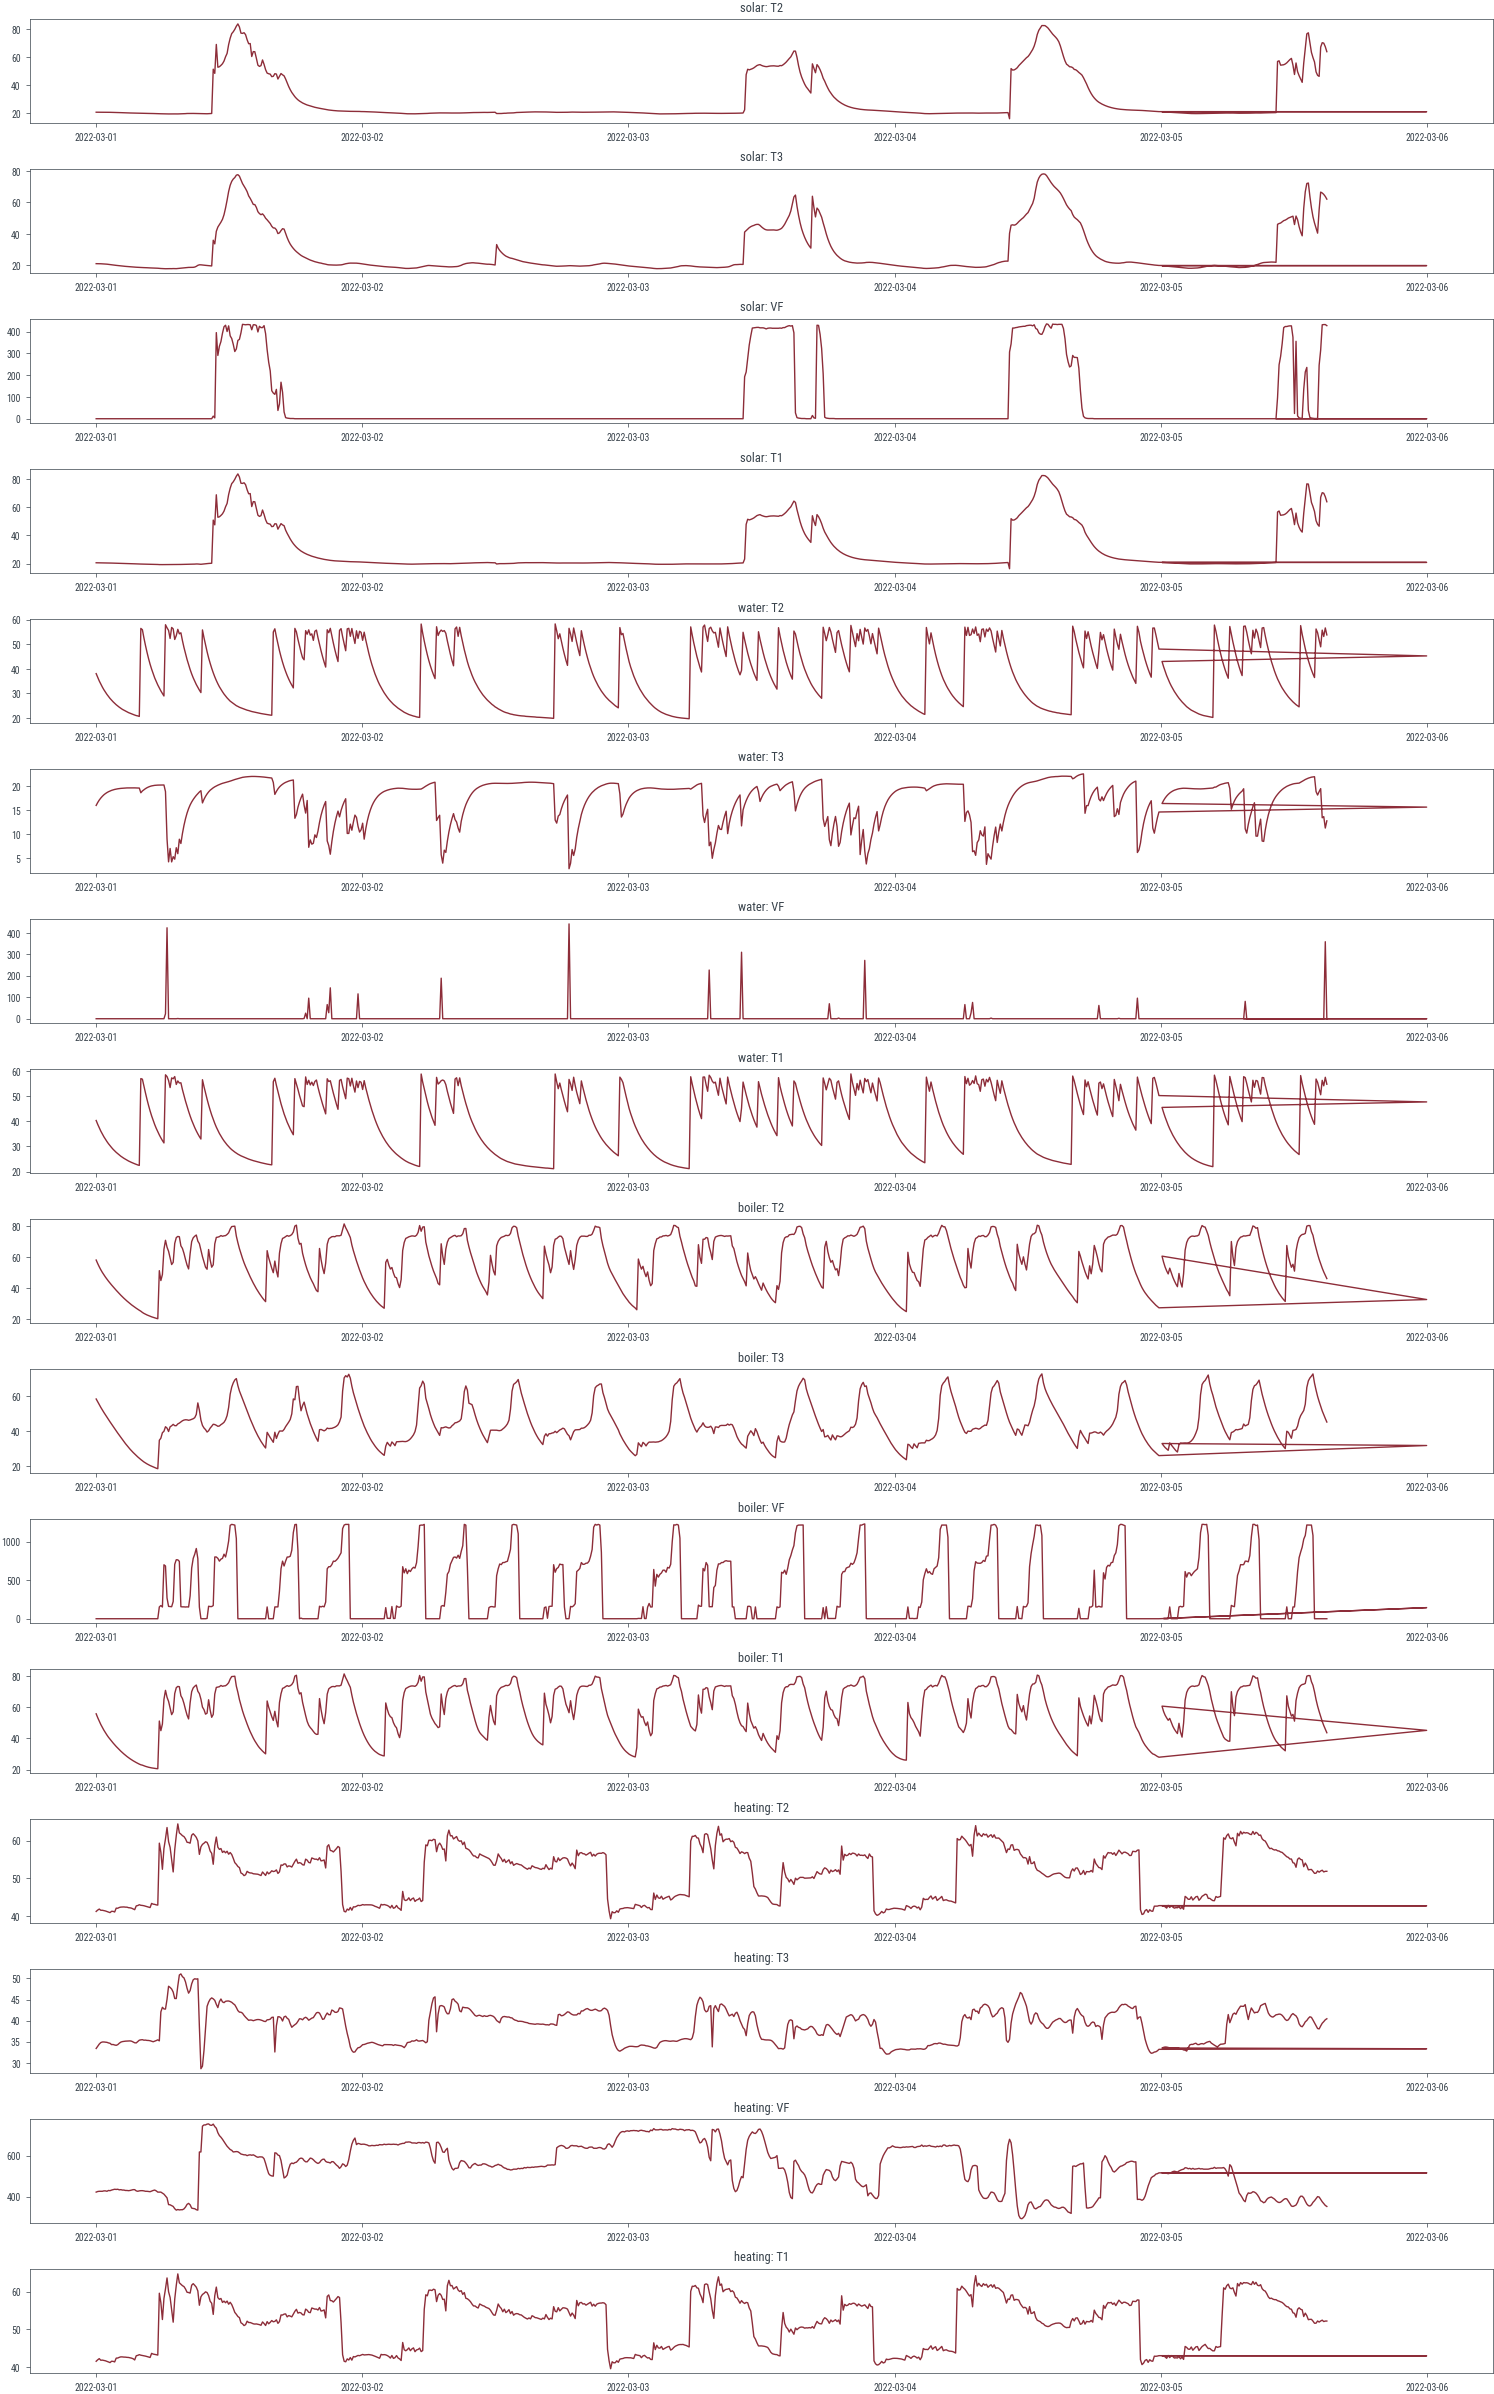

In [41]:
variables = {'T1', 'T2', 'T3', 'VF'}

# Circuit per row, variable per column
num_rows = len(CIRCUITS) * len(variables)
fig, axs = plt.subplots(num_rows, 1, figsize=(15, 1.5*num_rows))

T_SCALE = 5000

for idx1, circuit in enumerate(CIRCUITS.values()):
    for idx2, variable in enumerate(variables):
        row_idx = idx1 * len(variables) + idx2
        assert T_SCALE > 0
        T_END, T_STEP = len(dataframes[circuit]), 1
        if T_SCALE < 1:
            T_END = int(T_END * T_SCALE)
        else:
            T_STEP = int(T_SCALE)
        axs[row_idx].plot(dataframes[circuit]['datetime'].iloc[0:T_END:T_STEP], dataframes[circuit][variable].iloc[0:T_END:T_STEP])
        axs[row_idx].title.set_text(f"{circuit}: {variable}")